In [1]:
# install some requirement libraries
!pip install split-folders
!pip install torch-summary

  Obtaining dependency information for split-folders from https://files.pythonhosted.org/packages/b6/d5/307d63c03356bad6e141d8718d3f4116f51bd9c4b09e2614ffcee1f3c6fd/split_folders-0.5.1-py3-none-any.whl.metadata
  Obtaining dependency information for torch-summary from https://files.pythonhosted.org/packages/ca/db/93d18c84f73b214acfa4d18051d6f4263eee3e044c408928e8abe941a22c/torch_summary-1.4.5-py3-none-any.whl.metadata


In [2]:
# import requirement libraries and tools
import os
import pathlib
import numpy as np
import splitfolders
import itertools
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchsummary import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import json
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train_json = '/kaggle/input/tig-aluminium-5083/al5083/train/train.json'

with open(train_json, 'r') as json_file:
    train_data_json = json.load(json_file)

In [5]:
test_json = '/kaggle/input/tig-aluminium-5083/al5083/test/test.json'

with open(test_json, 'r') as json_file:
    test_data_json = json.load(json_file)

In [6]:
label_names = ["good weld", "burn through", "contamination", "lack of fusion", "misalignment", "lack of penetration"]
labels = [0, 1, 2, 3, 4, 5]
labels = torch.tensor(labels)
one_hot_encoding = F.one_hot(labels, num_classes=6)
label_count = [0, 0, 0, 0, 0, 0]

In [7]:
for l in train_data_json:
    label_count[train_data_json[l]] += 1
    
label_count

[8758, 1783, 6325, 4028, 2953, 2819]

In [8]:
label_count_test = [0, 0, 0, 0, 0, 0]
for l in test_data_json:
    label_count_test[test_data_json[l]] += 1
    
label_count_test

[2189, 351, 2078, 1007, 729, 234]

In [9]:
all_data = []
all_image_data = []
image_size = (256, 256)
label_count = [0, 0, 0, 0, 0, 0]

## Data is not balanced. Images of different classes : [8758, 1783, 6325, 4028, 2953, 2819]

WE LOAD 2001 IMAGES OF EACH CLASS 

In [10]:
def load_data(path):
    transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]
    )
    
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                
                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = train_data_json[key_name]
                
                if label_count[label] > 2000:
                    continue
                    
                label_count[label] += 1
                image = Image.open(img_path)              
                all_data.append((image, one_hot_encoding[label]))
                
                all_image_data.append((transform(image), one_hot_encoding[label]))
                if len(all_data) % 100 == 0:
                    print(f"Total images loaded : {len(all_data)}, Label count : {label_count}", end='\r')

In [11]:
load_data('/kaggle/input/tig-aluminium-5083/al5083/train')


In [12]:
random.shuffle(all_data)
random.shuffle(all_image_data)

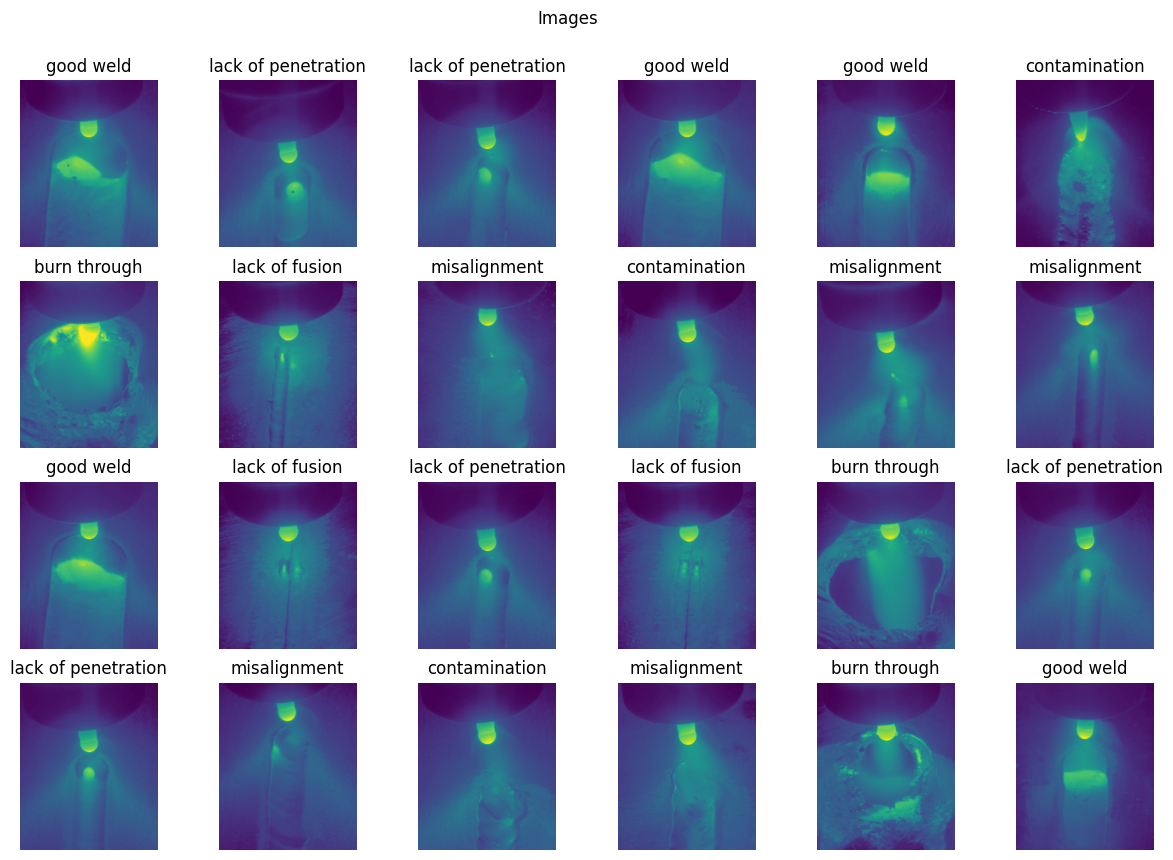

In [13]:
# visualizing the dataset for check it
labels_map = {
    0: "good weld", 
    1: "burn through",
    2: "contamination",
    3: "lack of fusion",
    4: "misalignment",
    5: "lack of penetration",
}

figure = plt.figure(figsize=(15, 10))
cols, rows = 6, 4
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    img = all_data[np.random.randint(low = 0, high = len(all_data))]
    N = img[1].tolist() 
    lab = 6
    for j in range(len(N)):
        if N[j]==1:
            lab = N.index(N[j])         
    plt.title(labels_map[lab])
    plt.axis("off")
    plt.imshow(img[0])
    plt.suptitle('Images', y=0.95)
plt.show()

In [14]:
sample_image = all_image_data[np.random.randint(low = 0, high = len(all_data))]
sample_image

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0745, 0.0745, 0.0745],
          [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0784, 0.0745],
          [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0784, 0.0745],
          ...,
          [0.0902, 0.0824, 0.0627,  ..., 0.1922, 0.1882, 0.1882],
          [0.0941, 0.0902, 0.0706,  ..., 0.1922, 0.1843, 0.1843],
          [0.0941, 0.0902, 0.0706,  ..., 0.1882, 0.1843, 0.1843]]]),
 tensor([1, 0, 0, 0, 0, 0]))

In [15]:
print(type(sample_image))
sample_image[0].size()

<class 'tuple'>


torch.Size([1, 256, 256])

In [16]:
Train = all_image_data[:int(0.7*len(all_image_data))]
Test = all_image_data[int(0.7*len(all_image_data)):]

In [17]:
Real_test_set = Test[:int(0.5*len(Test))]
val_set = Test[int(0.5*len(Test)):]

In [18]:
print(len(Real_test_set))
print(len(val_set))


1768
1769


In [19]:
# import and load train, validation and test set
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    Train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    Real_test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

class_names = ("good weld", "burn through", "contamination", "lack of fusion", "misalignment", "lack of penetration")

In [20]:
# define function for train model

def train(model, train_loader, validation_loader, device, loss_fn, optimizer, num_epochs, patience=5):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_model_wts = model.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            # Print shapes for debugging
            #print(f"outputs shape: {outputs.shape}")
            #print(f"labels shape: {labels.shape}")

            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                # Print shapes for debugging
                #print(f"Validation outputs shape: {outputs.shape}")
                #print(f"Validation labels shape: {labels.shape}")

                # Convert one-hot encoded labels to class indices
                labels = torch.argmax(labels, dim=1)

                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(validation_loader)
        val_acc = correct / total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        """

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        """

        print(f'Epoch {epoch + 1}/{num_epochs}.. '
              f'train_loss: {train_loss:.4f} | '
              f'val_loss: {val_loss:.4f} | ' +
              f'train_acc: {train_acc:.4f} | ' +
              f'val_acc: {val_acc:.4f}', '\n')
        
       
    model.load_state_dict(best_model_wts)
    return history, model.state_dict()

    
# ---------------------------------------------------------------

# ------------------------------------------------------------------

def evaluate(model, data_loader, device, loss_fn):
    """
    Evaluate models and return loss and accuracy of model
        model: created model
        data_loader: test or validation loader
        device: available device for train model (cpu or cuda)
        loss_fn: defined loss function
    """

    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, nn.tensor([0.0, 1.0, 2.0, 3.0, 4.0, 5.0]))
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = total_loss / len(data_loader)
    val_acc = correct / total

    return val_loss, val_acc

# -------------------------------------------------------------------

# ------------------------------------------------------------------

def plot_comparision_result(model):
    """
    Plot diagram of accuracy and loss for train and validation set
        model: created model
    """
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot train and validation accuracy
    axs[0].plot(model['history']['train_acc'], color="red", marker="o")
    axs[0].plot(model['history']['val_acc'], color="blue", marker="h")
    axs[0].set_title('Accuracy Comparison between Train & Validation Set')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc="lower right")
    
    # Plot train and validation loss
    axs[1].plot(model['history']['train_loss'], color="red", marker="o")
    axs[1].plot(model['history']['val_loss'], color="blue", marker="h")
    axs[1].set_title('Loss Comparison between Train & Validation Set')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc="upper right")

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------

# ------------------------------------------------------------------

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes of our target (key=categorical type, value=numerical type)
    """
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in classes.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in classes.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

In [21]:
# Define first CNN Model: 1 conv layer | 1 pool layer | 2 full-connected layer | RelU activation
class Model2(nn.Module):
    def __init__(self, dim_output):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
               
        self.fc1 = nn.Linear(in_features=16 * 61 * 61, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=dim_output)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))  
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_2 = Model2(6)

### <strong>Explanation of Calculations for Model2 Class</strong>

Let's break down the calculations step-by-step for the `Model2` class, focusing on the changes in dimensions after each convolution and pooling operation.

#### Initial Setup:
- **Input image size**: 256x256 pixels
- **Grayscale image**, so the number of channels: 1

#### First Convolution and Pooling Layer:
1. **First Convolution Layer**:
   - `self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)`
   - **Input dimensions**: 256x256x1
   - **Kernel size**: 5x5
   - **Stride**: 1 (default)
   - **Padding**: 0 (default)
   - **Output dimensions calculation**: 
     - Output height and width = \((256 - 5 + 1) = 252\)
     - Number of channels after this layer: 6
   - **Output dimensions**: 252x252x6

2. **First Pooling Layer**:
   - `self.pool = nn.MaxPool2d(kernel_size=2, stride=2)`
   - **Input dimensions**: 252x252x6
   - **Kernel size**: 2x2
   - **Stride**: 2
   - **Output dimensions calculation**: 
     - Output height and width = \(252 / 2 = 126\)
     - Number of channels remains the same: 6
   - **Output dimensions**: 126x126x6

#### Second Convolution and Pooling Layer:
3. **Second Convolution Layer**:
   - `self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)`
   - **Input dimensions**: 126x126x6
   - **Kernel size**: 5x5
   - **Stride**: 1 (default)
   - **Padding**: 0 (default)
   - **Output dimensions calculation**: 
     - Output height and width = \((126 - 5 + 1) = 122\)
     - Number of channels after this layer: 16
   - **Output dimensions**: 122x122x16

4. **Second Pooling Layer**:
   - `self.pool = nn.MaxPool2d(kernel_size=2, stride=2)`
   - **Input dimensions**: 122x122x16
   - **Kernel size**: 2x2
   - **Stride**: 2
   - **Output dimensions calculation**: 
     - Output height and width = \(122 / 2 = 61\)
     - Number of channels remains the same: 16
   - **Output dimensions**: 61x61x16

#### Flattening:
After the second pooling layer, we need to flatten the output to pass it through the fully connected (linear) layers.

- **Input dimensions to the fully connected layer**: 61x61x16
- **Flattened size**: \(61 \times 61 \times 16 = 59536\)

#### Fully Connected Layers:
1. **First Fully Connected Layer**:
   - `self.fc1 = nn.Linear(in_features=16 * 61 * 61, out_features=120)`
   - Input features: 59536
   - Output features: 120

2. **Second Fully Connected Layer**:
   - `self.fc2 = nn.Linear(in_features=120, out_features=84)`
   - Input features: 120
   - Output features: 84

3. **Third Fully Connected Layer**:
   - `self.fc3 = nn.Linear(in_features=84, out_features=dim_output)`
   - Input features: 84
   - Output features: 6 (number of classes)

#### Forward Pass:
In the forward pass, the image passes through each layer in the following order:
1. Convolution -> ReLU -> Pooling
2. Convolution -> ReLU -> Pooling
3. Flattening the output
4. Fully Connected -> ReLU
5. Fully Connected -> ReLU
6. Fully Connected -> Output

In [22]:
summary(model_2, (1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 252, 252]         156
├─MaxPool2d: 1-2                         [-1, 6, 126, 126]         --
├─Conv2d: 1-3                            [-1, 16, 122, 122]        2,416
├─MaxPool2d: 1-4                         [-1, 16, 61, 61]          --
├─Linear: 1-5                            [-1, 120]                 7,144,440
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 6]                   510
Total params: 7,157,686
Trainable params: 7,157,686
Non-trainable params: 0
Total mult-adds (M): 52.40
Input size (MB): 0.25
Forward/backward pass size (MB): 4.73
Params size (MB): 27.30
Estimated Total Size (MB): 32.28


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 252, 252]         156
├─MaxPool2d: 1-2                         [-1, 6, 126, 126]         --
├─Conv2d: 1-3                            [-1, 16, 122, 122]        2,416
├─MaxPool2d: 1-4                         [-1, 16, 61, 61]          --
├─Linear: 1-5                            [-1, 120]                 7,144,440
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 6]                   510
Total params: 7,157,686
Trainable params: 7,157,686
Non-trainable params: 0
Total mult-adds (M): 52.40
Input size (MB): 0.25
Forward/backward pass size (MB): 4.73
Params size (MB): 27.30
Estimated Total Size (MB): 32.28

In [23]:
# get Device for Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(f"Using {device} device")

Using cuda device


In [24]:
# mode model to GPU
model_2 = model_2.to(device)
model_2

Model2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [25]:
# define a Loss function and optimizer for model_2
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.0001)

In [26]:
# train model_2
import time
start = time.time()
history_2, best_model_weights_2 = train(model_2, train_loader, val_loader,
                                        device, loss_fn, optimizer, num_epochs=100)

end = time.time() - start
print("Training time : ", end, "secs.")

Epoch 1/100.. train_loss: 0.9463 | val_loss: 0.1567 | train_acc: 0.7083 | val_acc: 0.9695 

Epoch 2/100.. train_loss: 0.1129 | val_loss: 0.0710 | train_acc: 0.9718 | val_acc: 0.9842 

Epoch 3/100.. train_loss: 0.0539 | val_loss: 0.0426 | train_acc: 0.9851 | val_acc: 0.9887 

Epoch 4/100.. train_loss: 0.0336 | val_loss: 0.0186 | train_acc: 0.9912 | val_acc: 0.9949 

Epoch 5/100.. train_loss: 0.0321 | val_loss: 0.0219 | train_acc: 0.9912 | val_acc: 0.9943 

Epoch 6/100.. train_loss: 0.0175 | val_loss: 0.0065 | train_acc: 0.9956 | val_acc: 0.9983 

Epoch 7/100.. train_loss: 0.0134 | val_loss: 0.0073 | train_acc: 0.9965 | val_acc: 0.9983 

Epoch 8/100.. train_loss: 0.0103 | val_loss: 0.0132 | train_acc: 0.9977 | val_acc: 0.9955 

Epoch 9/100.. train_loss: 0.0161 | val_loss: 0.0143 | train_acc: 0.9947 | val_acc: 0.9949 

Epoch 10/100.. train_loss: 0.0063 | val_loss: 0.0446 | train_acc: 0.9988 | val_acc: 0.9847 

Epoch 11/100.. train_loss: 0.0097 | val_loss: 0.0023 | train_acc: 0.9977 | val_

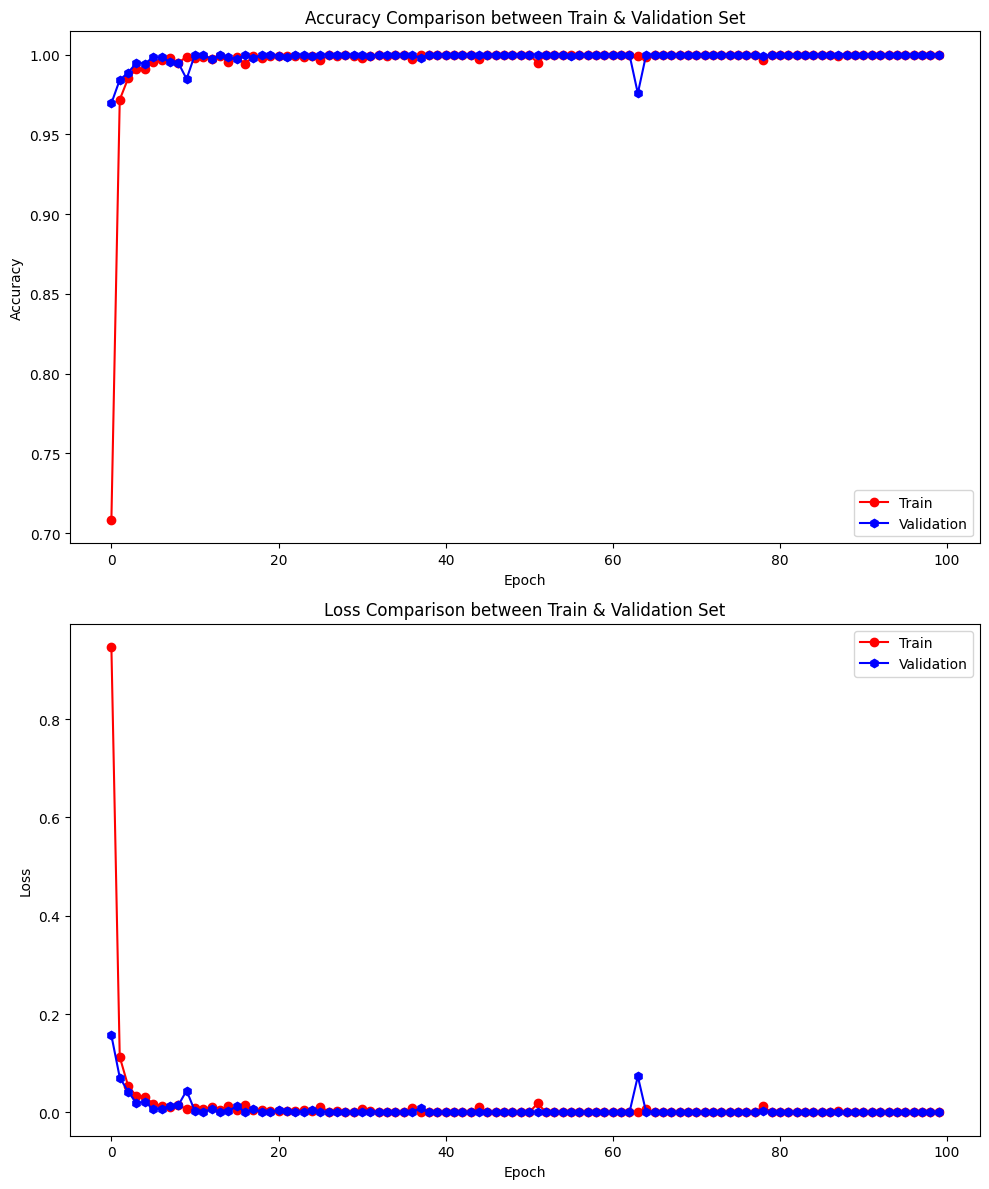

In [27]:
# create dict for store result of train models
size_histories_2 = {}
# store train results
size_histories_2['Model 2'] = {'history':history_2, 'weights':best_model_weights_2 }
# plot accuracy and loss diagram per epoch for model_1  
plot_comparision_result(size_histories_2['Model 2'])

In [28]:
def get_true_and_pred_labels(loader, model):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    # Print lengths for debugging
    print(f"Length of true_labels: {len(true_labels)}")
    print(f"Length of pred_labels: {len(pred_labels)}")

    return true_labels, pred_labels

Length of true_labels: 1769
Length of pred_labels: 1769
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       329
           1       1.00      1.00      1.00       242
           2       1.00      1.00      1.00       301
           3       1.00      1.00      1.00       297
           4       1.00      1.00      1.00       299
           5       1.00      1.00      1.00       301

    accuracy                           1.00      1769
   macro avg       1.00      1.00      1.00      1769
weighted avg       1.00      1.00      1.00      1769
 




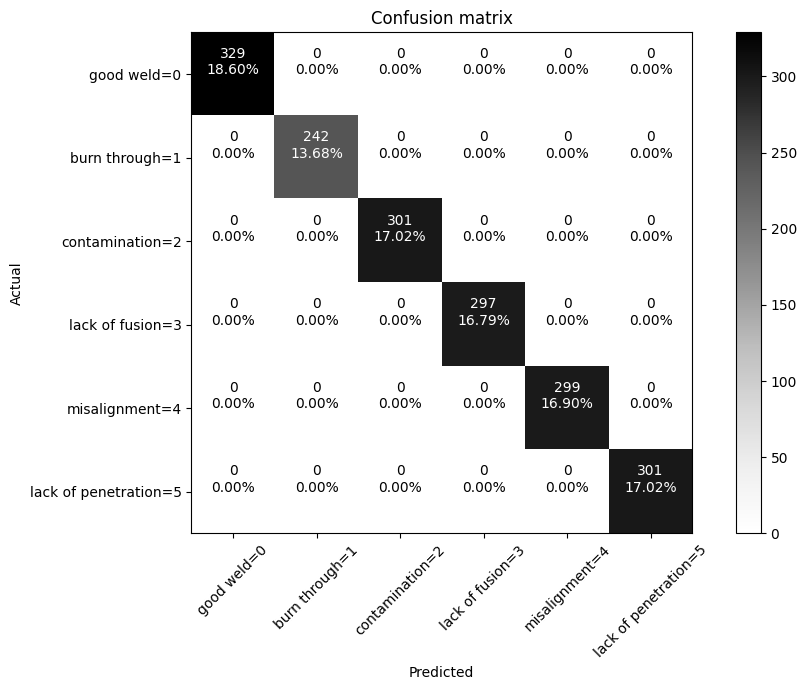

In [29]:
# check confusion matrix for error analysis
y_true_2, y_pred_2 = get_true_and_pred_labels(val_loader, model_2)

print(classification_report(y_true_2, y_pred_2), '\n\n')
cm = confusion_matrix(y_true_2, y_pred_2)

classes = {
    0: "good weld", 
    1: "burn through",
    2: "contamination",
    3: "lack of fusion",
    4: "misalignment",
    5: "lack of penetration",
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys)

Length of true_labels: 1768
Length of pred_labels: 1768
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       306
           1       1.00      1.00      1.00       285
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       274
           4       1.00      1.00      1.00       274
           5       1.00      1.00      1.00       317

    accuracy                           1.00      1768
   macro avg       1.00      1.00      1.00      1768
weighted avg       1.00      1.00      1.00      1768
 




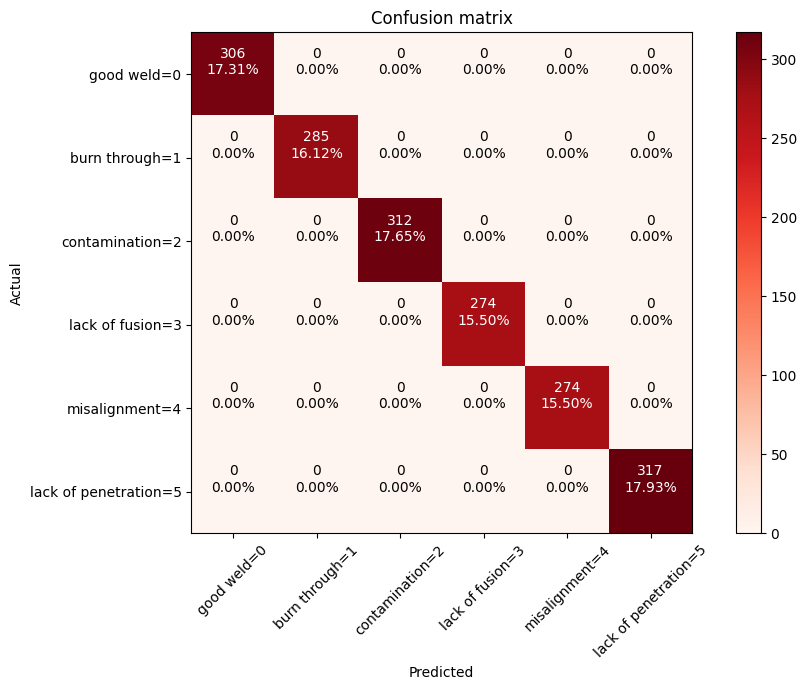

In [30]:
# check confusion matrix for error analysis
test_y_true_2, test_y_pred_2 = get_true_and_pred_labels(test_loader, model_2)

print(classification_report(test_y_true_2, test_y_pred_2), '\n\n')
cm = confusion_matrix(test_y_true_2, test_y_pred_2)

classes = {
    0: "good weld", 
    1: "burn through",
    2: "contamination",
    3: "lack of fusion",
    4: "misalignment",
    5: "lack of penetration",
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds)